In [196]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from scipy.cluster.hierarchy import DisjointSet

Q1

In [197]:
class Network(object):
    def __init__(self, num_nodes):
        self.adj = {i: set() for i in range(num_nodes)}
        self.num_nodes = num_nodes

    def add_edge(self, i, j):
        self.adj[i].add(j)
        self.adj[j].add(i)

    def neighbors(self, i):
        return self.adj[i]

    def edge_list(self):
        return [(i, j) for i in self.adj for j in self.adj[i] if i < j]

class Poisson_Network(Network):
    def __init__(self, num_nodes, k_avg):
        super().__init__(num_nodes)

        S = np.array([i for i in range(num_nodes) for _ in range(np.random.poisson(k_avg))])
        S = np.random.permutation(S)
        if len(S) % 2:
            S = S[:-1]
        S = S.reshape(-1, 2)

        for k in range(len(S)):
            i, j = S[k][0], S[k][1]
            if i != j:
                self.add_edge(i, j)


class Geometric_Network(Network):
    def __init__(self, num_nodes, k_avg):
        super().__init__(num_nodes)

        S = np.array([i for i in range(num_nodes) for _ in range(np.random.geometric(1 / (k_avg + 1))-1)])
        S = np.random.permutation(S)
        if len(S) % 2:
            S = S[:-1]
        S = S.reshape(-1, 2)

        for k in range(len(S)):
            i, j = S[k][0], S[k][1]
            if i != j:
                self.add_edge(i, j)

In [198]:
class Infectious_Network():
    def __init__(self, network: Network, infection_probi: float, initial_infection: float):
        self.network = network
        self.infection_probi = infection_probi
        self.num_nodes = len(self.network.adj.keys())

        self.infectious = set()
        self.recovered = set()

        for _ in range(math.floor(initial_infection*self.num_nodes)):
            infect_node = np.random.randint(0, self.num_nodes)
            while infect_node in self.infectious:
                infect_node = np.random.randint(0, self.num_nodes)
            self.infectious.add(infect_node)

    def increment_time(self):
        new_infectious = set()
        for infect_node in self.infectious:
            for neighbour in self.network.neighbors(infect_node):
                if neighbour not in self.recovered and neighbour not in self.infectious and np.random.binomial(1, self.infection_probi):   
                    new_infectious.add(neighbour)
            self.recovered.add(infect_node)
        self.infectious = new_infectious


    def increment_till_extinction(self):
        S, I, R = [self.num_nodes-len(self.infectious)], [len(self.infectious)], [0]
        while len(self.infectious):
            self.increment_time()
            S.append(self.num_nodes-len(self.infectious)-len(self.recovered))
            I.append(len(self.infectious))
            R.append(len(self.recovered))

        return S, I, R

    # def iterative_outbreak_size(self, tol):
    #     s_array_new = np.random.rand(self.num_nodes)
    #     s_array = np.zeros(len(s_array_new))

    #     iter = 0
    #     while np.max(np.abs(s_array - s_array_new)) > tol and iter < 20:
    #         s_array = s_array_new.copy()
    #         s_array_new = np.ones(len(s_array))
    #         for i in range(len(s_array)):
    #             s_i = s_array[i]
    #             for j in self.network.neighbors(i):
    #                 s_array_new[i] *= (1 - self.infection_probi + s_array[j] * self.infection_probi)
    #         iter += 1
        
    #     return self.num_nodes - np.sum(s_array_new > 0.5)

    def disjoint_set_outbreak_size(self):
        disjoint = DisjointSet(range(self.num_nodes))

        for i, j in self.network.edge_list():
            if np.random.binomial(1, self.infection_probi):
                disjoint.merge(i, j)
        num_nodes_infected = [disjoint.subset_size(node) for node in range(self.num_nodes)]
        mean = np.mean(num_nodes_infected)
        std = np.std(num_nodes_infected)

        return mean, std/mean 


In [199]:
def iterative_outbreak_size(network: Network, infection_probi, tol):
    s_array_new = np.random.rand(network.num_nodes)
    s_array = np.zeros(len(s_array_new))

    iter = 0
    while np.max(np.abs(s_array - s_array_new)) > tol and iter < 20:
        s_array = s_array_new.copy()
        s_array_new = np.ones(len(s_array))
        for i in range(len(s_array)):
            s_i = s_array[i]
            for j in network.neighbors(i):
                s_array_new[i] *= (1 - infection_probi + s_array[j] * infection_probi)
        iter += 1
    
    return network.num_nodes - np.sum(s_array_new > 0.5)

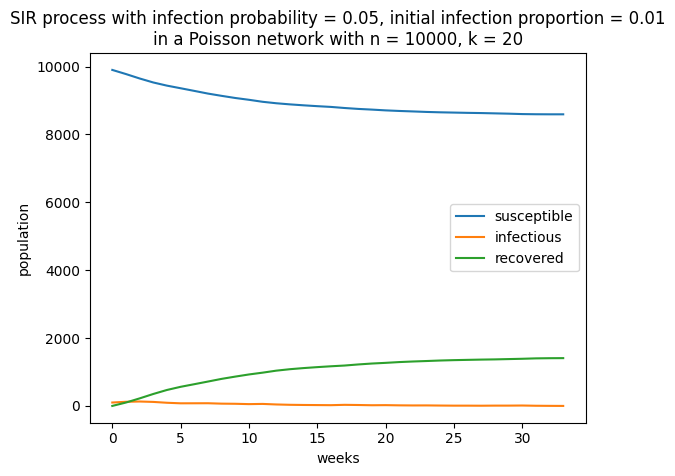

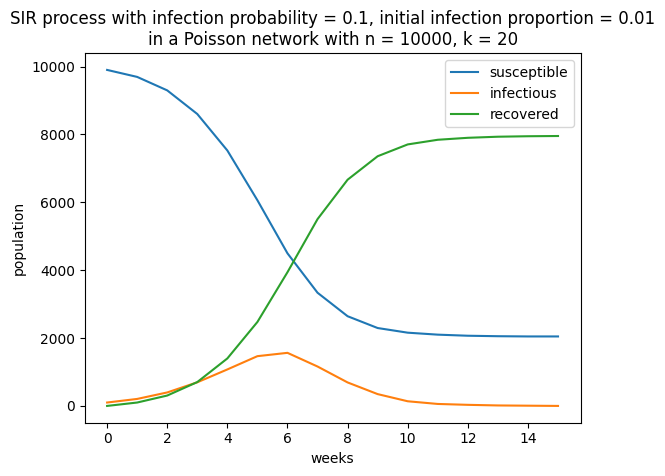

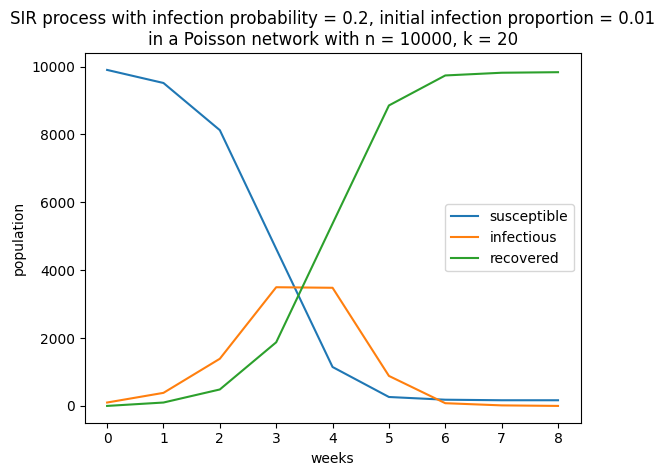

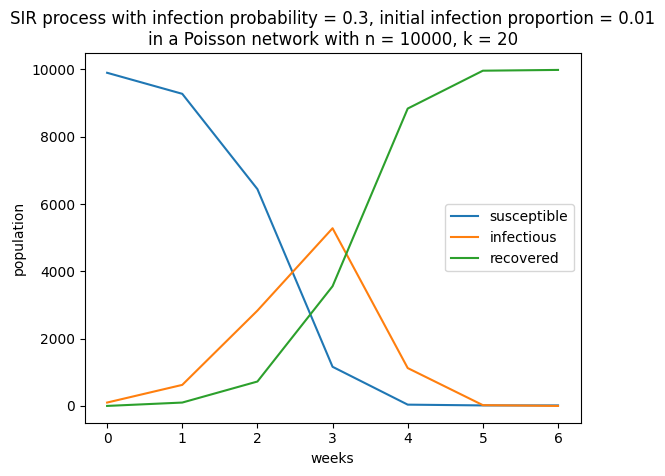

In [200]:
n, k = 10000, 20
poisson_network = Poisson_Network(n, k)
initial_infection = 0.01

for infection_probi in [0.05, 0.1, 0.2, 0.3]:
    infectious_network = Infectious_Network(poisson_network, infection_probi, initial_infection)
    S, I, R = infectious_network.increment_till_extinction()
    time = np.arange(0, len(S), 1)
    plt.plot(time, S, label="susceptible")
    plt.plot(time, I, label="infectious")
    plt.plot(time, R, label="recovered")
    plt.legend()
    plt.title(f"SIR process with infection probability = {infection_probi}, initial infection proportion = {initial_infection}\nin a Poisson network with n = {n}, k = {k}")
    plt.xlabel("weeks")
    plt.ylabel("population")
    plt.show()

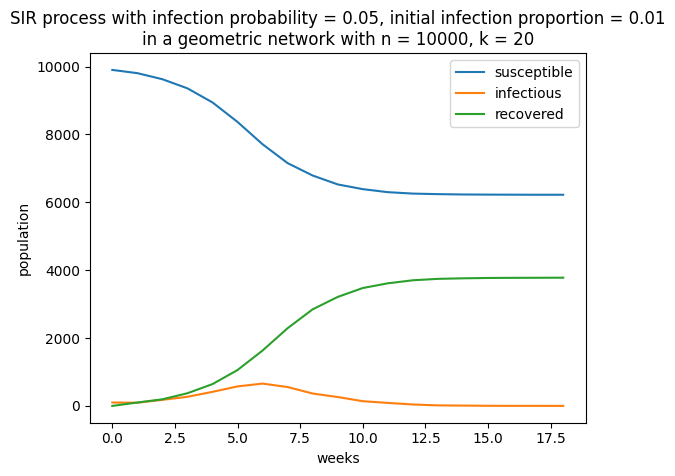

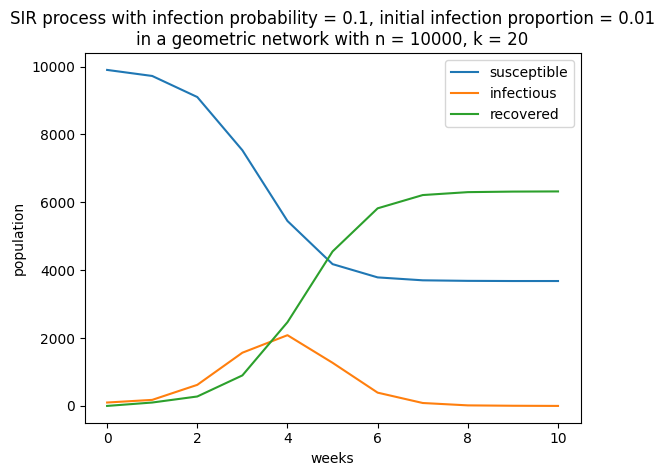

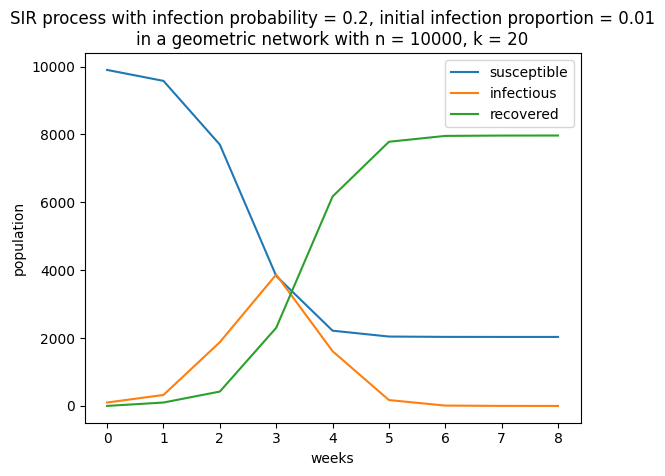

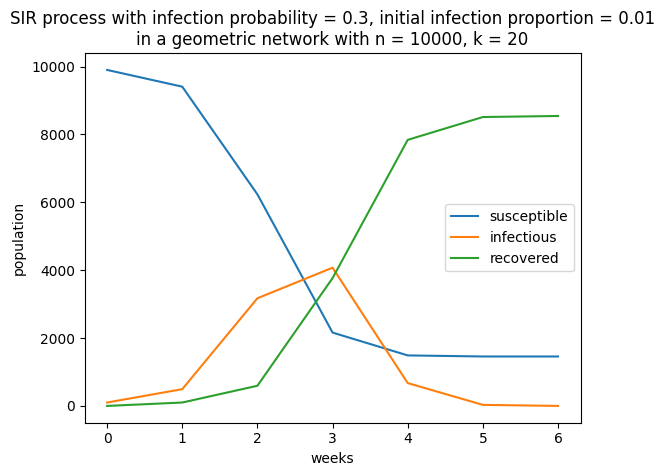

In [201]:
n, k = 10000, 20
geometric_network = Geometric_Network(n, k)
initial_infection = 0.01

for infection_probi in [0.05, 0.1, 0.2, 0.3]:
    infectious_network = Infectious_Network(geometric_network, infection_probi, initial_infection)
    S, I, R = infectious_network.increment_till_extinction()
    time = np.arange(0, len(S), 1)
    plt.plot(time, S, label="susceptible")
    plt.plot(time, I, label="infectious")
    plt.plot(time, R, label="recovered")
    plt.legend()
    plt.title(f"SIR process with infection probability = {infection_probi}, initial infection proportion = {initial_infection}\nin a geometric network with n = {n}, k = {k}")
    plt.xlabel("weeks")
    plt.ylabel("population")
    plt.show()

Q2, 3

In [202]:
infection_probi_array = np.linspace(0, 1, 100)
sample_size = 1
poisson_network = Poisson_Network(n, k)
case_outbreak_array = []


for infection_probi in infection_probi_array:
    total_case_outbreak = 0
    for _ in range(sample_size):
        infectious_network = Infectious_Network(poisson_network, infection_probi, initial_infection)
        infectious_network.increment_till_extinction()
        total_case_outbreak += len(infectious_network.recovered)
    
    case_outbreak_array.append(total_case_outbreak / sample_size)

In [203]:
iterative_case_outbreak_array = []
tol = 0.001

for infection_probi in infection_probi_array:
    infectious_network = Infectious_Network(poisson_network, infection_probi, initial_infection)
    outbreak = iterative_outbreak_size(poisson_network, infection_probi, tol)
    iterative_case_outbreak_array.append(outbreak)

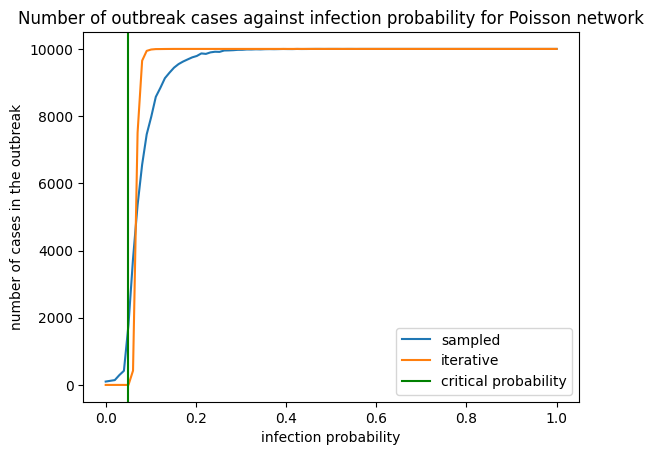

In [204]:
critical_probi_poisson = 0.05

plt.plot(infection_probi_array, case_outbreak_array, label="sampled")
plt.plot(infection_probi_array, iterative_case_outbreak_array, label="iterative")
plt.axvline(critical_probi_poisson, label="critical probability", color="green")
plt.legend()
plt.xlabel("infection probability")
plt.ylabel("number of cases in the outbreak")
plt.title("Number of outbreak cases against infection probability for Poisson network")
plt.show()

In [205]:
infection_probi_array = np.linspace(0, 1, 100)
sample_size = 1
geometric_network = Geometric_Network(n, k)
case_outbreak_array_geometric = []

for infection_probi in infection_probi_array:
    total_case_outbreak = 0
    for _ in range(sample_size):
        infectious_network = Infectious_Network(geometric_network, infection_probi, initial_infection)
        infectious_network.increment_till_extinction()
        total_case_outbreak += len(infectious_network.recovered)
    
    case_outbreak_array_geometric.append(total_case_outbreak / sample_size)

In [ ]:
iterative_case_outbreak_array_geometric = []
tol = 0.001

for infection_probi in infection_probi_array:
    infectious_network = Infectious_Network(geometric_network, infection_probi, initial_infection)
    outbreak = iterative_outbreak_size(geometric_network, infection_probi, tol)
    iterative_case_outbreak_array_geometric.append(outbreak)
    print(f"Infection probi: {infection_probi}, outbreak: {outbreak}")

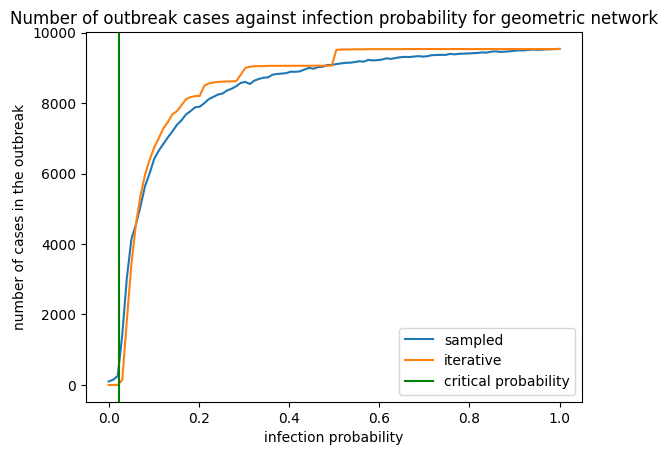

In [207]:
critical_probi_geometric = 0.0238

plt.plot(infection_probi_array, case_outbreak_array_geometric, label="sampled")
plt.plot(infection_probi_array, iterative_case_outbreak_array_geometric, label="iterative")
plt.axvline(critical_probi_geometric, label="critical probability", color="green")
plt.legend()
plt.xlabel("infection probability")
plt.ylabel("number of cases in the outbreak")
plt.title("Number of outbreak cases against infection probability for geometric network")
plt.show()

Q4

In [208]:
infection_probi_array_3crit = np.linspace(0, 3*critical_probi_poisson, 50)
mean_array = []
coeff_of_var_array = []

for infection_probi in infection_probi_array_3crit:
    infectious_network = Infectious_Network(poisson_network, infection_probi, initial_infection)
    mean, coeff_of_var = infectious_network.disjoint_set_outbreak_size()
    mean_array.append(mean)
    coeff_of_var_array.append(coeff_of_var)   


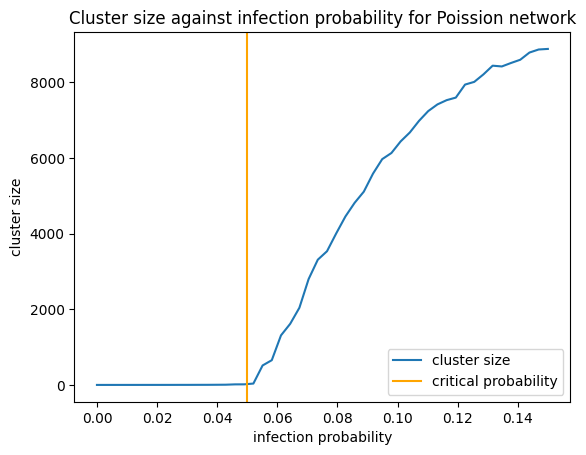

In [209]:
plt.plot(infection_probi_array_3crit, mean_array, label="cluster size")
plt.axvline(critical_probi_poisson, label="critical probability", color="orange")
plt.title("Cluster size against infection probability for Poission network")
plt.legend()
plt.xlabel("infection probability")
plt.ylabel("cluster size")
plt.show()

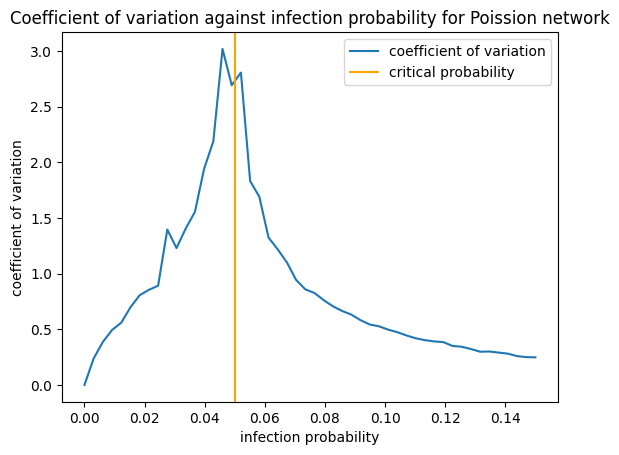

In [210]:
plt.plot(infection_probi_array_3crit, coeff_of_var_array, label="coefficient of variation")
plt.axvline(critical_probi_poisson, label="critical probability", color="orange")
plt.title("Coefficient of variation against infection probability for Poission network")
plt.legend()
plt.xlabel("infection probability")
plt.ylabel("coefficient of variation")
plt.show()

In [211]:
infection_probi_array_3crit_geometric = np.linspace(0, 3*critical_probi_geometric, 50)
mean_array_geometric = []
coeff_of_var_array_geometric = []

for infection_probi in infection_probi_array_3crit_geometric:
    infectious_network = Infectious_Network(geometric_network, infection_probi, initial_infection)
    mean, coeff_of_var = infectious_network.disjoint_set_outbreak_size()
    mean_array_geometric.append(mean)
    coeff_of_var_array_geometric.append(coeff_of_var)   

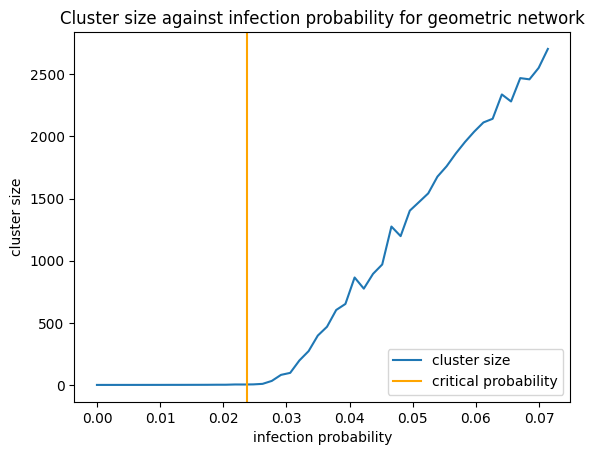

In [212]:
plt.plot(infection_probi_array_3crit_geometric, mean_array_geometric, label="cluster size")
plt.axvline(critical_probi_geometric, label="critical probability", color="orange")
plt.title("Cluster size against infection probability for geometric network")
plt.legend()
plt.xlabel("infection probability")
plt.ylabel("cluster size")
plt.show()

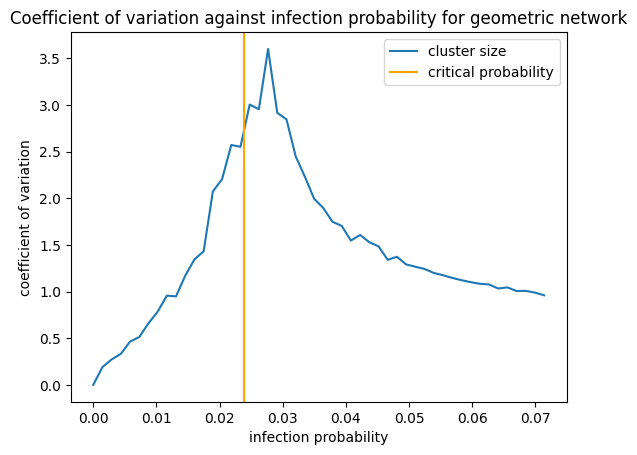

In [213]:
plt.plot(infection_probi_array_3crit_geometric, coeff_of_var_array_geometric, label="cluster size")
plt.axvline(critical_probi_geometric, label="critical probability", color="orange")
plt.title("Coefficient of variation against infection probability for geometric network")
plt.legend()
plt.xlabel("infection probability")
plt.ylabel("coefficient of variation")
plt.show()

Q5

In [214]:
def one_sweep_outbreak_size(network, node):
    disjoint = DisjointSet(range(n))
    edge_list_random = network.edge_list()
    np.random.shuffle(edge_list_random)
    m = len(edge_list_random)
    c_i_k = np.ones((m+1)) # m: k

    for k in range(m):
        i, j = edge_list_random[k]
        disjoint.merge(i, j)
        c_i_k[k+1] = disjoint.subset_size(node)

    return c_i_k

def c_lambda(c_i_k, infection_probi):
    m = len(c_i_k) - 1
    k_array = np.arange(0, m+1, 1)
    probability_array = scipy.stats.binom.pmf(k_array, m, infection_probi)

    return sum(probability_array*c_i_k)


In [215]:
# Poisson
i = 0
poisson_c_i_k = one_sweep_outbreak_size(poisson_network, i)
outbreak_size = []

for infection_probi in infection_probi_array:
    c_lambda_val = c_lambda(poisson_c_i_k, infection_probi)
    outbreak_size.append(c_lambda_val)

outbreak_size = np.array(outbreak_size)

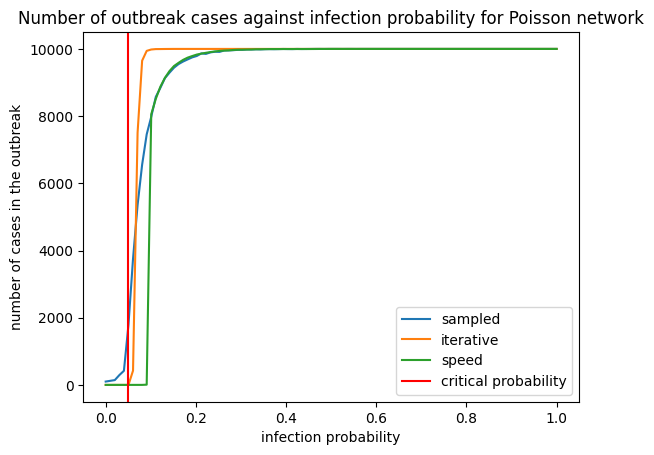

In [216]:
critical_probi_poisson = 0.05

plt.plot(infection_probi_array, case_outbreak_array, label="sampled")
plt.plot(infection_probi_array, iterative_case_outbreak_array, label="iterative")
plt.plot(infection_probi_array, outbreak_size, label="speed")
plt.axvline(critical_probi_poisson, label="critical probability", color="red")
plt.legend()
plt.xlabel("infection probability")
plt.ylabel("number of cases in the outbreak")
plt.title("Number of outbreak cases against infection probability for Poisson network")
plt.show()

In [223]:
# Geometric
i = 0
geometric_c_i_k = one_sweep_outbreak_size(geometric_network, i)
outbreak_size_geometric = []

for infection_probi in infection_probi_array:
    c_lambda_val = c_lambda(geometric_c_i_k, infection_probi)
    outbreak_size_geometric.append(c_lambda_val)

outbreak_size_geometric = np.array(outbreak_size_geometric)

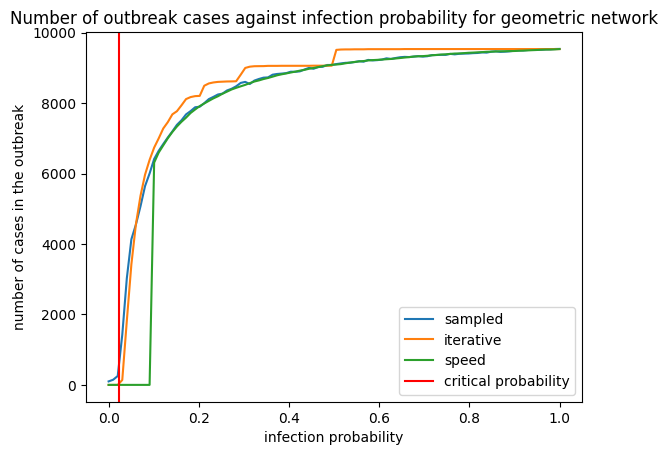

: 

In [224]:
critical_probi_geometric = 0.0238

plt.plot(infection_probi_array, case_outbreak_array_geometric, label="sampled")
plt.plot(infection_probi_array, iterative_case_outbreak_array_geometric, label="iterative")
plt.plot(infection_probi_array, outbreak_size_geometric, label="speed")
plt.axvline(critical_probi_geometric, label="critical probability", color="red")
plt.legend()
plt.xlabel("infection probability")
plt.ylabel("number of cases in the outbreak")
plt.title("Number of outbreak cases against infection probability for geometric network")
plt.show()